In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import Models.Get_data as Gd
import numpy as np
import random
from Models.GAE_LSTM import GAE_LSTM_seq2seq
from torchinfo import summary
import pickle
import os
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import scipy
import torch_geometric

from torch.optim.lr_scheduler import LinearLR

In [2]:
latent_space = 25
window_size = 10
step_size = 3
# batch_size = 5

# 获取目录路径
dirpath = os.path.dirname(f'/home/wl4023/github repos/IRP/predict result/Latent space {latent_space}/a.txt')
# 创建目录（如果不存在）
os.makedirs(dirpath, exist_ok=True)



num_mp_layers = [2, 2, 2]
num_clusters = [1000, latent_space]
clusters = torch.load(f'/home/wl4023/github repos/IRP/result/Latent space {latent_space}/clusters.pt')
centroids = torch.load(f'/home/wl4023/github repos/IRP/result/Latent space {latent_space}/centroids.pt')

In [3]:
# def set_seed(seed):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# set_seed(66)  # 你可以选择任意一个数字作为种子
# 启用浮点数异常检测
# torch.autograd.set_detect_anomaly(True)
directory = '/home/wl4023/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

In [4]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda:0


In [5]:
with open('/home/wl4023/github repos/IRP/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)
print(preprocessor.mean, preprocessor.std)

6.95707893371582 9.811119079589844


In [6]:
xyfile = "/home/wl4023/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
pos = torch.tensor(np.load(xyfile), dtype=torch.float32)

sparse_graph = scipy.sparse.load_npz('/home/wl4023/data/Sibo_22Mar2024/new_sparse_matrix.npz')
indices = np.array(sparse_graph.nonzero())
values = sparse_graph.data
shape = sparse_graph.shape

# sparse edge tensor
edge_tensor = torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float).coalesce()
edge_index = edge_tensor.indices()
edge_weight = edge_tensor.values()
edge_weight = edge_weight.unsqueeze(1)
print(edge_tensor.shape)
print(edge_index)
print(edge_weight)

print(f'{edge_weight.max():.8f}, {edge_weight.min():.8f}')

torch.Size([97149, 97149])
tensor([[    0,     0,     1,  ..., 97148, 97148, 97148],
        [    1,     3,     0,  ..., 97145, 97146, 97147]])
tensor([[0.0032],
        [0.0024],
        [0.0032],
        ...,
        [0.0039],
        [0.0043],
        [0.0038]])
0.02281803, 0.00025737


In [7]:
dataset, length = Gd.get_all_nodes(folders[:-1])
dataset = np.expand_dims(dataset[:, :, 0], axis=2)

print(dataset.shape)

dataset = torch.tensor(dataset, dtype=torch.float32)
dataset = Gd.segment_data_torch(dataset, length, window_size, step_size)

data = Gd.MyDataset(dataset[:, 0:5, :, :], dataset[:, -5:, :, :])
train_set, val_set = random_split(data, [0.8, 0.2])

(2900, 97149, 1)


## train

In [8]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))
    
class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

In [9]:
def train(model, train_set, val_set, criterion, metric, optimizer, scheduler=None, device=device, epochs=30, seq_len=5):
    train_NRMSELoss_list = []
    train_RMSELoss_list = []

    val_NRMSELoss_list = []
    val_RMSELoss_list = []

    min_loss = 10000
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_metric = 0
        for x, y in tqdm(train_set):
            input = preprocessor.transform(x).to(device)
            label = preprocessor.transform(y).to(device)
            # x, y = x.to(device), y.to(device)
            # x = x.to(device)
            optimizer.zero_grad()
            predict = model(input, seq_len, edge_index, edge_weight, pos)
            loss = criterion(label, predict)
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(),5)
            optimizer.step()

            recon_predict = preprocessor.inverse_transform(predict.cpu())
            # print(recon_predict.max(), train_loss, len(train_loader))
            train_loss += criterion(y, recon_predict).item()
            train_metric += metric(y, recon_predict).item()

            # train_loss += criterion(y.cpu(), predict.cpu()).item()
            # train_metric += metric(y.cpu(), predict.cpu()).item()
        if scheduler != None:
            scheduler.step()

        train_loss /= len(train_set)
        # print(train_loss, len(train_loader))
        train_metric /= len(train_set)
        train_RMSELoss_list.append(train_loss)
        train_NRMSELoss_list.append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_metric = 0
            for x, y in val_set:
                input = preprocessor.transform(x).to(device)
                # x = x.to(device)
                predict = model(input, seq_len, edge_index, edge_weight, pos)

                recon_predict = preprocessor.inverse_transform(predict.cpu())
                val_loss += criterion(y, recon_predict).item()
                val_metric += metric(y, recon_predict).item()
                # val_loss += criterion(y, predict.cpu()).item()
                # val_metric += metric(y, predict.cpu()).item()
    
            val_loss /= len(val_set)
            val_metric /= len(val_set)
            val_RMSELoss_list.append(val_loss)
            val_NRMSELoss_list.append(val_metric)

        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {train_loss}, NRMSE_train_loss: {train_metric}, val Loss: {val_loss}, NRMSE_val_loss: {val_metric}')
        
        if min_loss >= val_metric:
            min_loss = val_metric
            torch.save(model.state_dict(), f'/home/wl4023/github repos/IRP/predict result/Latent space {latent_space}/GAE_LSTM.pth')

    return train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list

In [10]:
# Define the weights initialization function
def initialize_weights(m):
    # if isinstance(m, torch.nn.Linear):
    #     torch.nn.init.kaiming_uniform_(m.weight)
    #     if m.bias is not None:
    #         torch.nn.init.constant_(m.bias, 1e-8)
    if isinstance(m, torch_geometric.nn.GCNConv):
        torch.nn.init.xavier_normal_(m.lin.weight)
        # print(True)
        if m.lin.bias is not None:
            torch.nn.init.constant_(m.lin.bias, 0)




In [11]:
model = GAE_LSTM_seq2seq(latent_space=latent_space,
                         hidden_size=100,
                         input_node_channel=1,
                         output_node_channel=1,
                         num_mp_layers=num_mp_layers,
                         clusters=clusters,
                         centroids=centroids,
                         hidden_channels=16,
                         n_mlp_mp=3)

# model.apply(initialize_weights)
summary(model, input_data=(preprocessor.transform(data[0][0]), 5, edge_index, edge_weight, pos))

Layer (type:depth-idx)                                  Output Shape              Param #
GAE_LSTM_seq2seq                                        [5, 97149, 1]             --
├─GAE_LSTM_encoder: 1-1                                 [16, 100]                 --
│    └─Encoder: 2-1                                     [25, 16]                  963
│    │    └─ModuleList: 3-189                           --                        (recursive)
│    │    └─ELU: 3-2                                    [97149, 16]               --
│    │    └─ModuleList: 3-189                           --                        (recursive)
│    │    └─ELU: 3-4                                    [97149, 16]               --
│    │    └─ModuleList: 3-189                           --                        (recursive)
│    │    └─ELU: 3-6                                    [97149, 16]               --
│    │    └─ModuleList: 3-229                           --                        (recursive)
│    │    └─ELU: 3-8   

In [12]:
model = model.to(device)
edge_index, edge_weight, pos = edge_index.to(device), edge_weight.to(device), pos.to(device)
optimizer = optim.Adam(model.parameters())
criterion = RMSELoss()
metric = NRMSE(dataset)

# scheduler = LinearLR(optimizer, start_factor=0.2, end_factor=1.0, total_iters=30, last_epoch=-1)

train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list = train(model,
                                                                                         train_set,
                                                                                         val_set,
                                                                                         criterion,
                                                                                         metric,
                                                                                         optimizer,
                                                                                         # scheduler=scheduler,
                                                                                         device=device,
                                                                                         epochs=50,
                                                                                         seq_len=5)

100%|██████████| 720/720 [01:36<00:00,  7.44it/s]


Epoch 1/50, train Loss: 6.453536967933178, NRMSE_train_loss: 0.12402912256721821, val Loss: 5.110987549054556, NRMSE_val_loss: 0.09822695754863862


100%|██████████| 720/720 [01:37<00:00,  7.36it/s]


Epoch 2/50, train Loss: 4.725270914990041, NRMSE_train_loss: 0.09081395362089906, val Loss: 4.190562687439625, NRMSE_val_loss: 0.08053751256545828


100%|██████████| 720/720 [01:37<00:00,  7.38it/s]


Epoch 3/50, train Loss: 4.005805499810312, NRMSE_train_loss: 0.07698670428039299, val Loss: 3.7348402044293603, NRMSE_val_loss: 0.07177908111405273


100%|██████████| 720/720 [01:37<00:00,  7.38it/s]


Epoch 4/50, train Loss: 3.614869389972753, NRMSE_train_loss: 0.06947338824522578, val Loss: 3.355238457132318, NRMSE_val_loss: 0.06448359804633776


100%|██████████| 720/720 [01:37<00:00,  7.42it/s]


Epoch 5/50, train Loss: 3.3695592791669897, NRMSE_train_loss: 0.06475882665836252, val Loss: 3.2724957271328186, NRMSE_val_loss: 0.0628933830488494


100%|██████████| 720/720 [01:33<00:00,  7.72it/s]


Epoch 6/50, train Loss: 3.134756974420614, NRMSE_train_loss: 0.060246212276655976, val Loss: 3.0135563398872676, NRMSE_val_loss: 0.05791688348327935


100%|██████████| 720/720 [01:32<00:00,  7.76it/s]


Epoch 7/50, train Loss: 2.949727864935994, NRMSE_train_loss: 0.056690178002463655, val Loss: 2.8670492387017723, NRMSE_val_loss: 0.05510119566766743


100%|██████████| 720/720 [01:38<00:00,  7.33it/s]


Epoch 8/50, train Loss: 2.8172911351339684, NRMSE_train_loss: 0.05414490542284006, val Loss: 2.7177350809121266, NRMSE_val_loss: 0.0522315593009721


100%|██████████| 720/720 [01:39<00:00,  7.27it/s]


Epoch 9/50, train Loss: 2.717468261470397, NRMSE_train_loss: 0.052226431204083684, val Loss: 3.388401820006983, NRMSE_val_loss: 0.06512095767213812


100%|██████████| 720/720 [01:38<00:00,  7.31it/s]


Epoch 10/50, train Loss: 2.704290139178435, NRMSE_train_loss: 0.0519731636708861, val Loss: 2.7848953664635814, NRMSE_val_loss: 0.053522298089098495


100%|██████████| 720/720 [01:39<00:00,  7.27it/s]


Epoch 11/50, train Loss: 2.5368975223766435, NRMSE_train_loss: 0.04875608144470284, val Loss: 2.556201048070492, NRMSE_val_loss: 0.049127071744673914


100%|██████████| 720/720 [01:38<00:00,  7.31it/s]


Epoch 12/50, train Loss: 2.439406800394257, NRMSE_train_loss: 0.04688242843581571, val Loss: 3.199879537747559, NRMSE_val_loss: 0.061497788730613345


100%|██████████| 720/720 [01:38<00:00,  7.30it/s]


Epoch 13/50, train Loss: 2.3540790879478055, NRMSE_train_loss: 0.045242533831494965, val Loss: 2.5410354715152828, NRMSE_val_loss: 0.048835607932349825


100%|██████████| 720/720 [01:32<00:00,  7.77it/s]


Epoch 14/50, train Loss: 2.1826549442691934, NRMSE_train_loss: 0.04194797041838885, val Loss: 2.2642538073009617, NRMSE_val_loss: 0.04351620126890237


100%|██████████| 720/720 [01:31<00:00,  7.88it/s]


Epoch 15/50, train Loss: 2.0944835497273337, NRMSE_train_loss: 0.04025342360837385, val Loss: 2.147916477152755, NRMSE_val_loss: 0.0412803395448367


100%|██████████| 720/720 [01:30<00:00,  7.96it/s]


Epoch 16/50, train Loss: 2.055668360946907, NRMSE_train_loss: 0.039507443039393464, val Loss: 2.0869225012190515, NRMSE_val_loss: 0.040108109418531705


100%|██████████| 720/720 [01:36<00:00,  7.48it/s]


Epoch 17/50, train Loss: 1.9749771217505137, NRMSE_train_loss: 0.0379566555765147, val Loss: 2.0793268837076324, NRMSE_val_loss: 0.0399621310045516


100%|██████████| 720/720 [01:33<00:00,  7.71it/s]


Epoch 18/50, train Loss: 1.897115040736066, NRMSE_train_loss: 0.03646024118061177, val Loss: 2.0871168508209994, NRMSE_val_loss: 0.04011184464380478


100%|██████████| 720/720 [01:29<00:00,  8.01it/s]


Epoch 19/50, train Loss: 1.9159859712753031, NRMSE_train_loss: 0.03682291749606116, val Loss: 2.0260048821651737, NRMSE_val_loss: 0.038937346970756126


100%|██████████| 720/720 [01:31<00:00,  7.89it/s]


Epoch 20/50, train Loss: 1.8558268675787581, NRMSE_train_loss: 0.03566673279532956, val Loss: 2.05643507488613, NRMSE_val_loss: 0.03952217825516725


100%|██████████| 720/720 [01:33<00:00,  7.72it/s]


Epoch 21/50, train Loss: 1.8265737880435255, NRMSE_train_loss: 0.035104524102320685, val Loss: 1.9505865184288451, NRMSE_val_loss: 0.03748789794129117


100%|██████████| 720/720 [01:33<00:00,  7.73it/s]


Epoch 22/50, train Loss: 1.7891701242989964, NRMSE_train_loss: 0.03438567133400486, val Loss: 1.8912374405554553, NRMSE_val_loss: 0.03634728089120635


100%|██████████| 720/720 [01:30<00:00,  7.95it/s]


Epoch 23/50, train Loss: 1.7589699057241281, NRMSE_train_loss: 0.03380525994709589, val Loss: 1.7844411810683138, NRMSE_val_loss: 0.03429478685782608


100%|██████████| 720/720 [01:25<00:00,  8.43it/s]


Epoch 24/50, train Loss: 1.7116431009024382, NRMSE_train_loss: 0.03289569631322391, val Loss: 1.8779509570345532, NRMSE_val_loss: 0.036091930909321626


100%|██████████| 720/720 [01:27<00:00,  8.18it/s]


Epoch 25/50, train Loss: 1.6985025432788663, NRMSE_train_loss: 0.032643150826010645, val Loss: 2.3445103085240837, NRMSE_val_loss: 0.04505863341934688


100%|██████████| 720/720 [01:27<00:00,  8.25it/s]


Epoch 26/50, train Loss: 1.7008821412920951, NRMSE_train_loss: 0.03268888386147511, val Loss: 1.7428202254479157, NRMSE_val_loss: 0.03349488266800952


100%|██████████| 720/720 [01:25<00:00,  8.42it/s]


Epoch 27/50, train Loss: 1.6719778064224455, NRMSE_train_loss: 0.03213337769977645, val Loss: 2.083839717191025, NRMSE_val_loss: 0.04004886193076076


100%|██████████| 720/720 [01:25<00:00,  8.46it/s]


Epoch 28/50, train Loss: 1.6482941161841154, NRMSE_train_loss: 0.03167820599693288, val Loss: 1.7286796062019285, NRMSE_val_loss: 0.03322311729588156


100%|██████████| 720/720 [01:26<00:00,  8.35it/s]


Epoch 29/50, train Loss: 1.67201433579127, NRMSE_train_loss: 0.032134079708743636, val Loss: 2.0675283049404953, NRMSE_val_loss: 0.03973537663715845


100%|██████████| 720/720 [01:24<00:00,  8.47it/s]


Epoch 30/50, train Loss: 1.6554480576680766, NRMSE_train_loss: 0.03181569600193244, val Loss: 2.044025951091138, NRMSE_val_loss: 0.03928369008701857


100%|██████████| 720/720 [01:23<00:00,  8.66it/s]


Epoch 31/50, train Loss: 1.6065638476775752, NRMSE_train_loss: 0.030876201063316937, val Loss: 1.9119307468723319, NRMSE_val_loss: 0.0367449810130095


100%|██████████| 720/720 [01:23<00:00,  8.63it/s]


Epoch 32/50, train Loss: 1.584004566570123, NRMSE_train_loss: 0.030442639189358387, val Loss: 1.976936570259446, NRMSE_val_loss: 0.037994313909666996


100%|██████████| 720/720 [01:25<00:00,  8.42it/s]


Epoch 33/50, train Loss: 1.6384255984177192, NRMSE_train_loss: 0.03148854501002158, val Loss: 2.062438120056131, NRMSE_val_loss: 0.039637549317249374


100%|██████████| 720/720 [01:37<00:00,  7.40it/s]


Epoch 34/50, train Loss: 1.5784939942260583, NRMSE_train_loss: 0.03033673258938102, val Loss: 1.8421170781444571, NRMSE_val_loss: 0.03540324727749691


100%|██████████| 720/720 [01:30<00:00,  7.98it/s]


Epoch 35/50, train Loss: 1.5503171880626017, NRMSE_train_loss: 0.029795208747964354, val Loss: 1.8762641082928833, NRMSE_val_loss: 0.03605951174739852


100%|██████████| 720/720 [01:29<00:00,  8.03it/s]


Epoch 36/50, train Loss: 1.5512542061921624, NRMSE_train_loss: 0.029813217089071663, val Loss: 1.6790300797483775, NRMSE_val_loss: 0.032268913735911335


100%|██████████| 720/720 [01:30<00:00,  7.93it/s]


Epoch 37/50, train Loss: 1.5190355976422627, NRMSE_train_loss: 0.02919401466885271, val Loss: 1.8121659617517247, NRMSE_val_loss: 0.03482762328999419


100%|██████████| 720/720 [01:29<00:00,  8.03it/s]


Epoch 38/50, train Loss: 1.5539579946133826, NRMSE_train_loss: 0.029865180653157748, val Loss: 1.6964111373078223, NRMSE_val_loss: 0.032602956515929385


100%|██████████| 720/720 [01:29<00:00,  8.03it/s]


Epoch 39/50, train Loss: 1.5017024325413837, NRMSE_train_loss: 0.02886089233151223, val Loss: 1.6269172055428254, NRMSE_val_loss: 0.03126736782626483


100%|██████████| 720/720 [01:30<00:00,  8.00it/s]


Epoch 40/50, train Loss: 1.5056232179618545, NRMSE_train_loss: 0.028936245027903675, val Loss: 1.7244218075075628, NRMSE_val_loss: 0.0331412874625257


100%|██████████| 720/720 [01:29<00:00,  8.02it/s]


Epoch 41/50, train Loss: 1.4945258227487406, NRMSE_train_loss: 0.02872296664152398, val Loss: 1.881870498620598, NRMSE_val_loss: 0.03616725961162641


100%|██████████| 720/720 [01:33<00:00,  7.69it/s]


Epoch 42/50, train Loss: 1.4754244609839386, NRMSE_train_loss: 0.028355861740419642, val Loss: 1.7846412437255157, NRMSE_val_loss: 0.034298631745031595


100%|██████████| 720/720 [01:35<00:00,  7.51it/s]


Epoch 43/50, train Loss: 1.4786218203604222, NRMSE_train_loss: 0.028417311053878316, val Loss: 1.5656530825452433, NRMSE_val_loss: 0.030089945974629686


100%|██████████| 720/720 [01:36<00:00,  7.47it/s]


Epoch 44/50, train Loss: 1.4565117875734965, NRMSE_train_loss: 0.027992383141018866, val Loss: 1.8292486253064437, NRMSE_val_loss: 0.035155931297772926


100%|██████████| 720/720 [01:34<00:00,  7.59it/s]


Epoch 45/50, train Loss: 1.4438214073578517, NRMSE_train_loss: 0.0277484894296827, val Loss: 1.9909488756896396, NRMSE_val_loss: 0.03826361322026263


100%|██████████| 720/720 [01:34<00:00,  7.60it/s]


Epoch 46/50, train Loss: 1.447209361443917, NRMSE_train_loss: 0.027813601823032108, val Loss: 1.6509887752586236, NRMSE_val_loss: 0.03172999411280262


100%|██████████| 720/720 [01:34<00:00,  7.60it/s]


Epoch 47/50, train Loss: 1.4560547461940183, NRMSE_train_loss: 0.027983599370216123, val Loss: 1.695100121491448, NRMSE_val_loss: 0.032577760486379684


100%|██████████| 720/720 [01:35<00:00,  7.56it/s]


Epoch 48/50, train Loss: 1.4717668183147907, NRMSE_train_loss: 0.028285566268540504, val Loss: 1.8845155963351607, NRMSE_val_loss: 0.03621809525862752


100%|██████████| 720/720 [01:30<00:00,  7.98it/s]


Epoch 49/50, train Loss: 1.4317073076963425, NRMSE_train_loss: 0.02751567118620086, val Loss: 1.5753422213000292, NRMSE_val_loss: 0.030276159472326494


100%|██████████| 720/720 [01:30<00:00,  7.99it/s]


Epoch 50/50, train Loss: 1.4216118353522487, NRMSE_train_loss: 0.027321648550504403, val Loss: 1.6636806396798716, NRMSE_val_loss: 0.0319739162307961


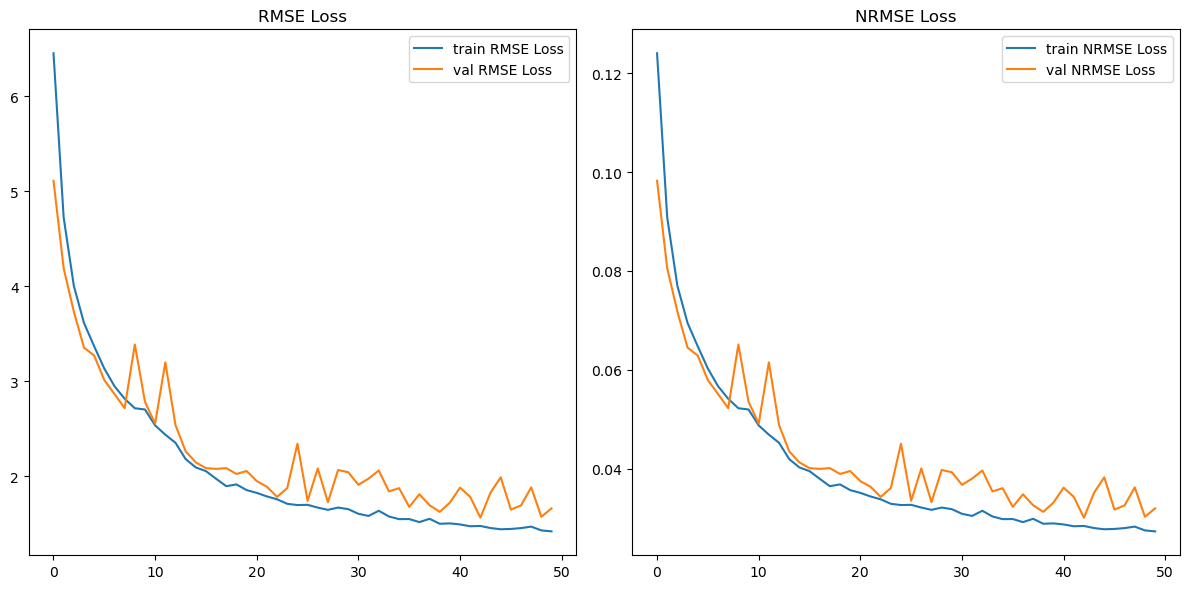

In [13]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list
axs[0].plot(train_RMSELoss_list, label='train RMSE Loss')
axs[0].plot(val_RMSELoss_list, label='val RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].plot(train_NRMSELoss_list, label='train NRMSE Loss')
axs[1].plot(val_NRMSELoss_list, label='val NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
# plt.savefig('CAE_train_loss.png')  # 你可以更改文件名或格式
plt.savefig(f'/home/wl4023/github repos/IRP/predict result/Latent space {latent_space}/GAE_LSTM_train_loss.png')
plt.show()

In [14]:
dataset, length = Gd.get_all_nodes(folders[-1:])
dataset = np.expand_dims(dataset[:, :, 0], axis=2)

dataset = torch.tensor(dataset, dtype=torch.float32)
dataset = Gd.segment_data_torch(dataset, length, window_size, step_size)

test_set = Gd.MyDataset(dataset[:, 0:5, :, :], dataset[:, -5:, :, :])

In [15]:
model = GAE_LSTM_seq2seq(latent_space=latent_space,
                         hidden_size=100,
                         input_node_channel=1,
                         output_node_channel=1,
                         num_mp_layers=num_mp_layers,
                         clusters=clusters,
                         centroids=centroids,
                         hidden_channels=16,
                         n_mlp_mp=3)
state_dict = torch.load(f'/home/wl4023/github repos/IRP/predict result/Latent space {latent_space}/GAE_LSTM.pth')
model.load_state_dict(state_dict)

criterion = RMSELoss()
metric = NRMSE(dataset)

In [16]:
test_RMSELoss_list = []
test_NRMSELoss_list = []

recon_predict_list = []

edge_index, edge_weight, pos = edge_index.cpu(), edge_weight.cpu(), pos.cpu()

model.eval()
with torch.no_grad():
    test_loss = 0
    test_metric = 0
    for x, y in test_set:
    # for i in range(10):
    #     x, y = train_set[i]
        input = preprocessor.transform(x.cpu())
        predict = model(input, 5, edge_index, edge_weight, pos)

        recon_predict = preprocessor.inverse_transform(predict)

        recon_predict_list.append(recon_predict)
        test_RMSELoss_list.append(criterion(y, recon_predict).item())
        test_NRMSELoss_list.append(metric(y, recon_predict).item())

recon_predict_list = torch.stack(recon_predict_list, dim=0).numpy()


test_rmse = np.array(test_RMSELoss_list)
test_nrmse = np.array(test_NRMSELoss_list)

test_loss = test_rmse.mean()
test_metric = test_nrmse.mean()

print(f'Ave test loss: {test_loss}, Ave test metric: {test_metric}')

Ave test loss: 1.5883405593133741, Ave test metric: 0.09032482245276051


In [17]:
recon_predict_list.shape

(31, 5, 97149, 1)

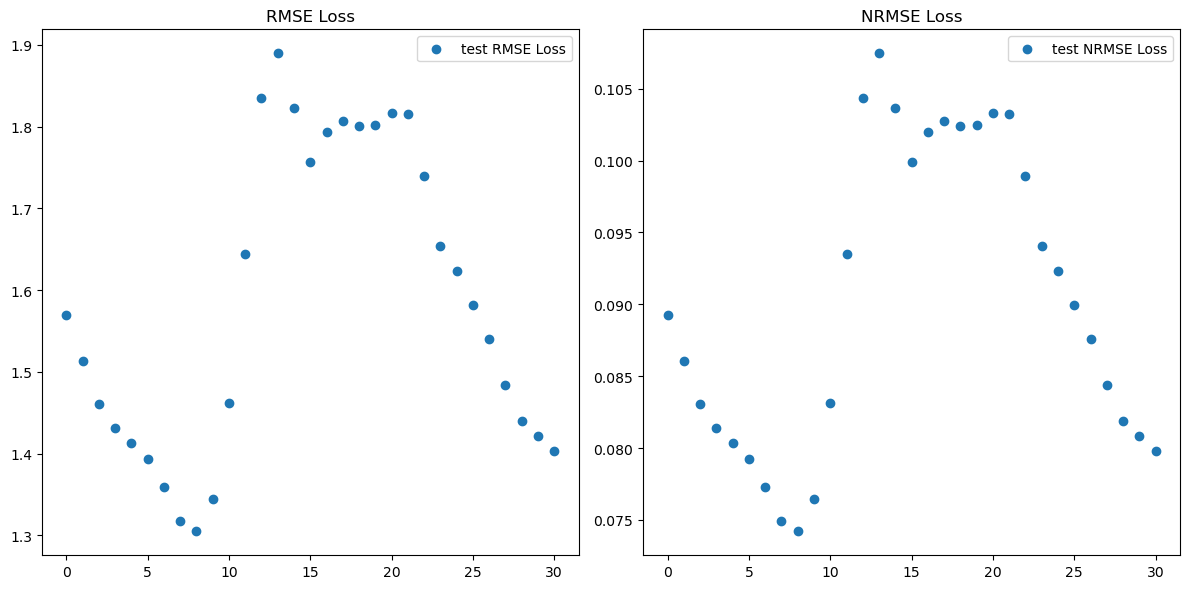

In [18]:
x = np.arange(0, len(test_set))


# 保存数组到 .npy 文件
# np.save('test_rmse.npy', test_rmse)
# np.save('test_nrmse.npy', test_nrmse)

fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(x, test_rmse, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].scatter(x, test_nrmse, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠

# plt.savefig('CAE_test_loss.png')  # 你可以更改文件名或格式
plt.savefig(f'/home/wl4023/github repos/IRP/predict result/Latent space {latent_space}/GAE_LSTM_test_loss.png')

plt.show()

In [19]:
def draw_pic(x, y, predict, coords):
    fig, axs = plt.subplots(3, 5, figsize=(30, 18))
    for i in range(axs.shape[-1]):
        axs[0][i].scatter(coords[:,0],coords[:,1],s = 5, c=x[i, :, :], cmap='bwr')
        axs[0][i].set_title(f'Origin Input {i+1}')

    for i in range(axs.shape[-1]):
        axs[1][i].scatter(coords[:,0],coords[:,1],s = 5, c=y[i, :, :], cmap='bwr')
        axs[1][i].set_title(f'Real Output {i+1}')

    for i in range(axs.shape[-1]):
        predict[i].shape
        axs[2][i].scatter(coords[:,0],coords[:,1],s = 5, c=predict[i], cmap='bwr')
        axs[2][i].set_title(f'Real Output {i+1}')

    plt.savefig(f'/home/wl4023/github repos/IRP/predict result/Latent space {latent_space}/GAE_LSTM_output.png')
    plt.show()
    plt.close()

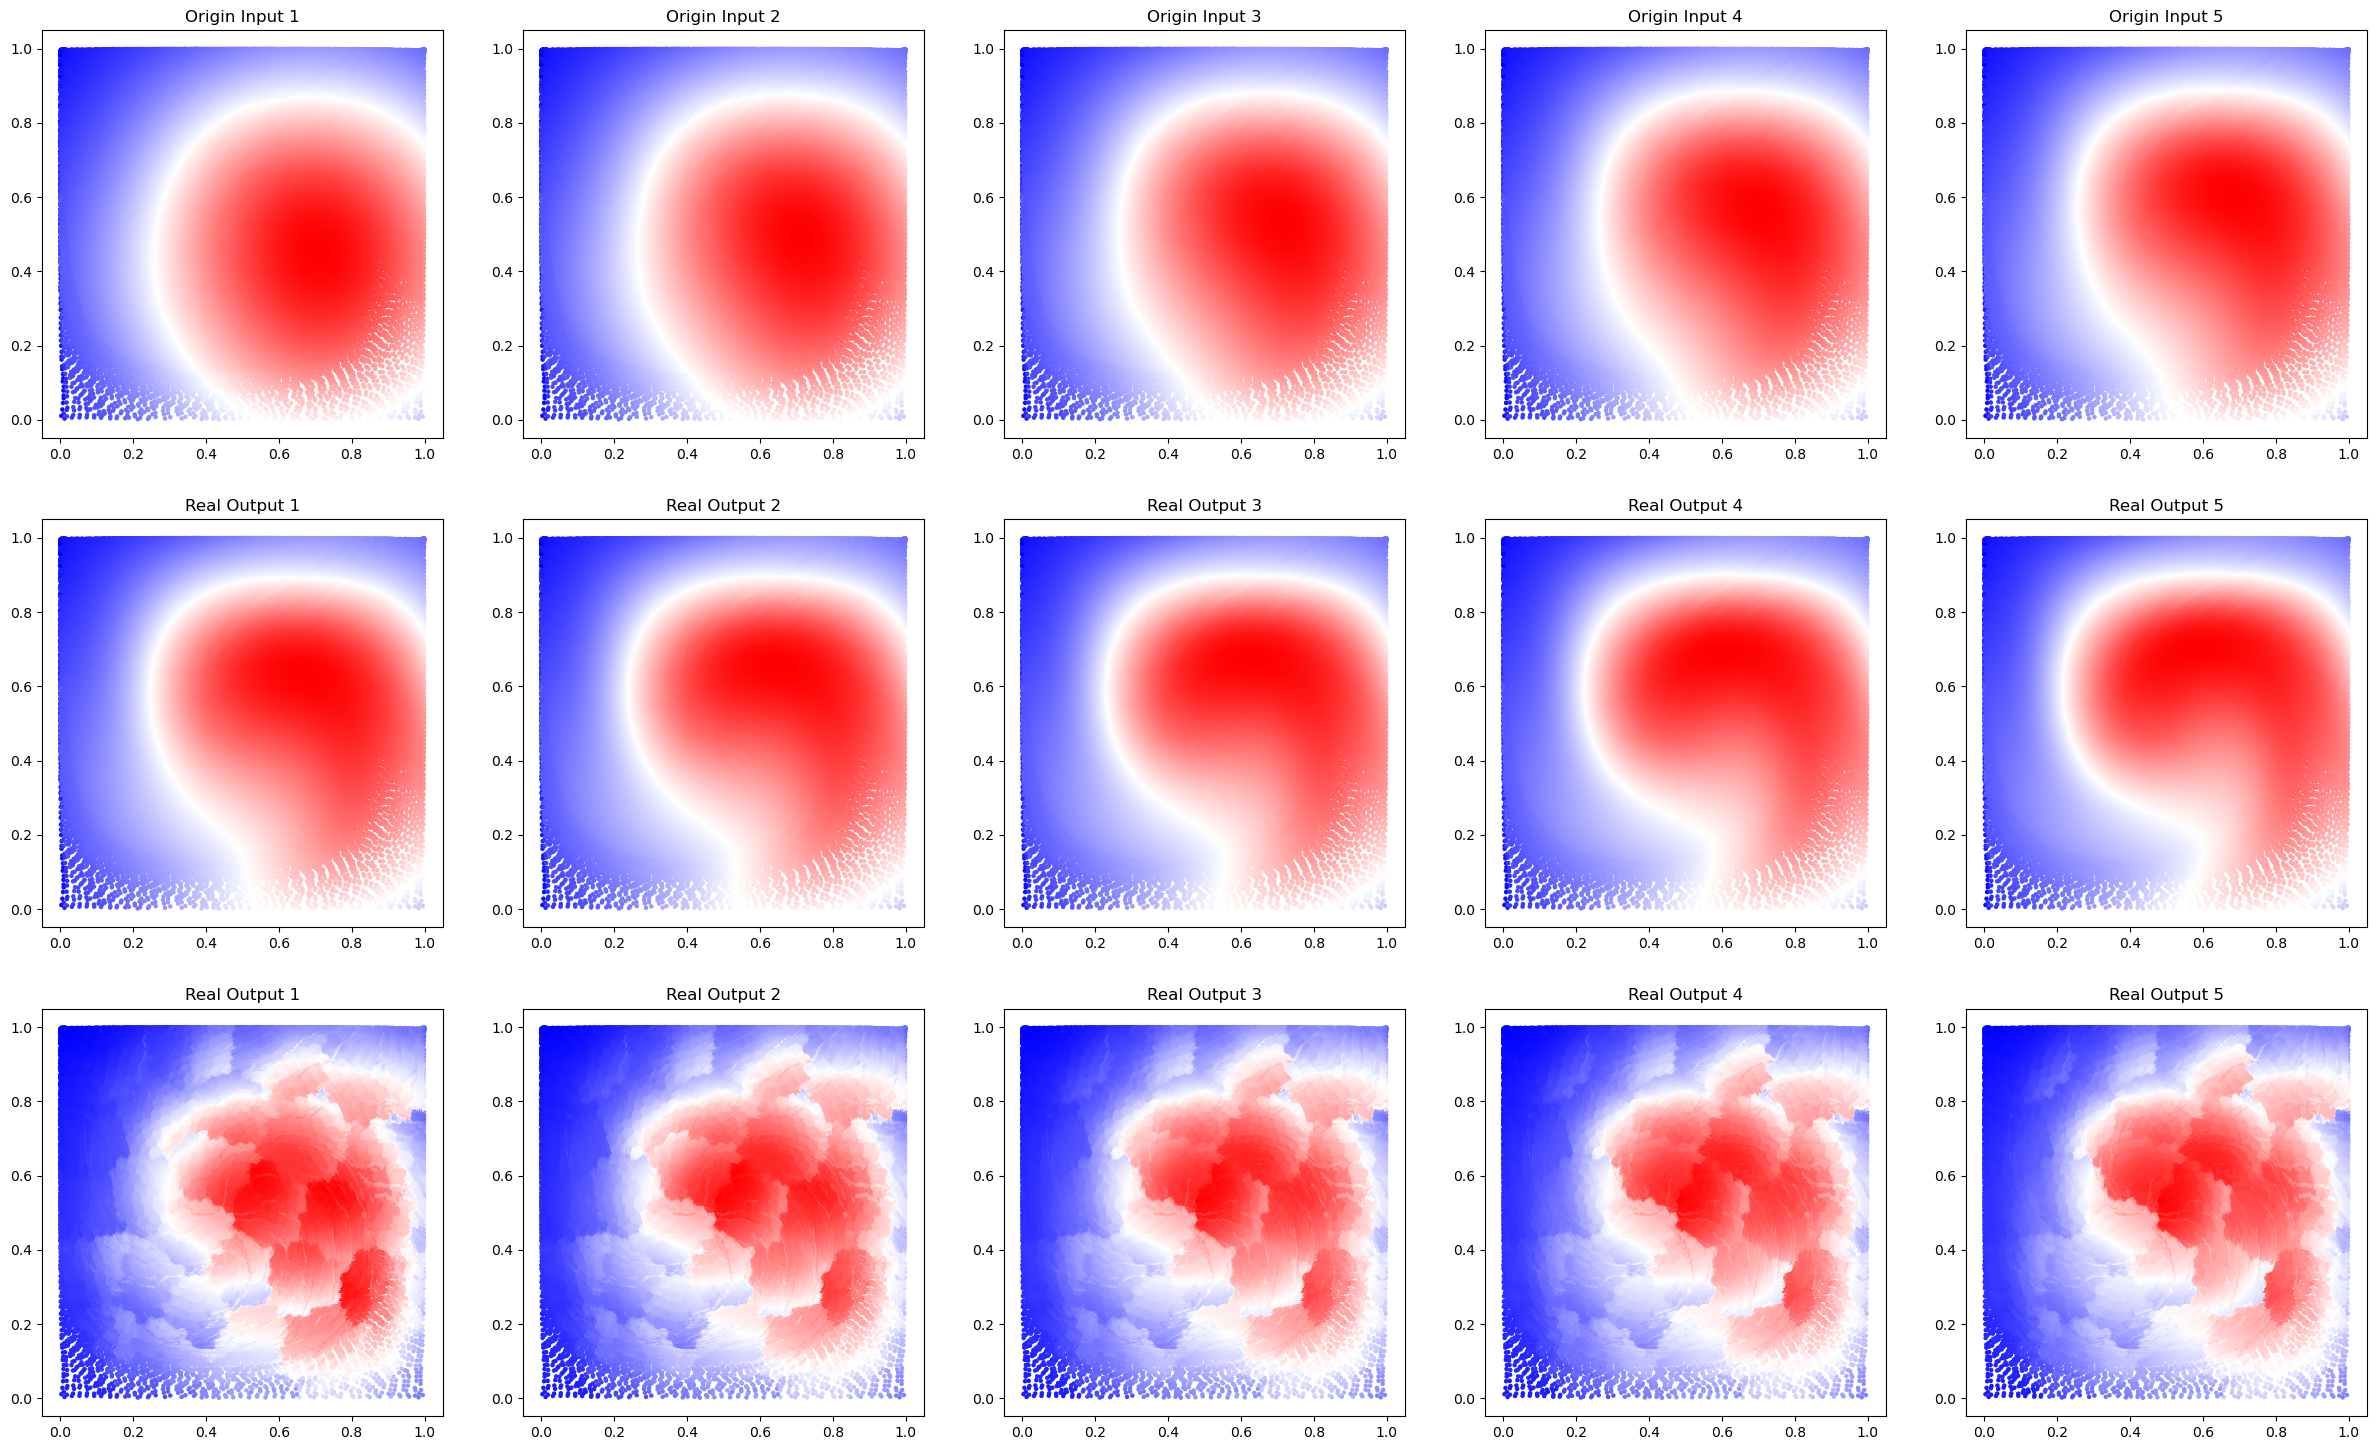

In [20]:
xyfile = "/home/wl4023/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
coords = np.load(xyfile)

x, y = test_set[0]
predict = recon_predict_list[0]
draw_pic(x, y, predict, coords)